In [41]:
%run wavelet_cnn.py
%run srPreprocessing.py

In [2]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15792663112888056486
]
[]


### Load images

In [3]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
obj_files = listdir(TRAIN_FILE )

In [4]:
len(obj_files)

496

In [5]:
#Load images
nb_images = 5
obj_img = load_images(TRAIN_FILE, nb_images)

(2040, 1356)


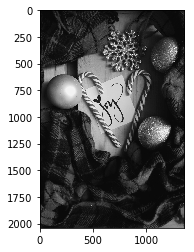

In [6]:
print(obj_img[0].shape)
plt.imshow(obj_img[0], 'gray')

### Generate train and test set

In [8]:
#Division by 4
window_size= 64
scale = 4
stride = 30

In [7]:
sub_samples, sub_labels = image_patches(obj_img, patch_size=64)

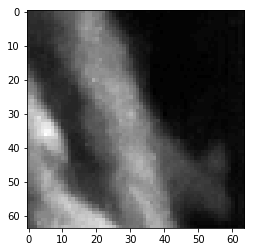

In [8]:
plt.imshow(sub_labels[10], 'gray')

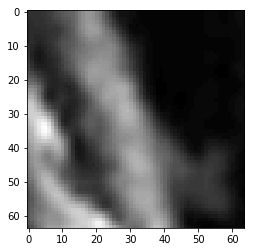

In [9]:
plt.imshow(sub_samples[10], 'gray')

#### Generate the wavelets subbands

In [11]:
test, train = get_wavelets_input(sub_labels, sub_samples)

In [12]:
train.shape

(60492, 4, 32, 32)

In [13]:
test.shape

(60492, 4, 32, 32)

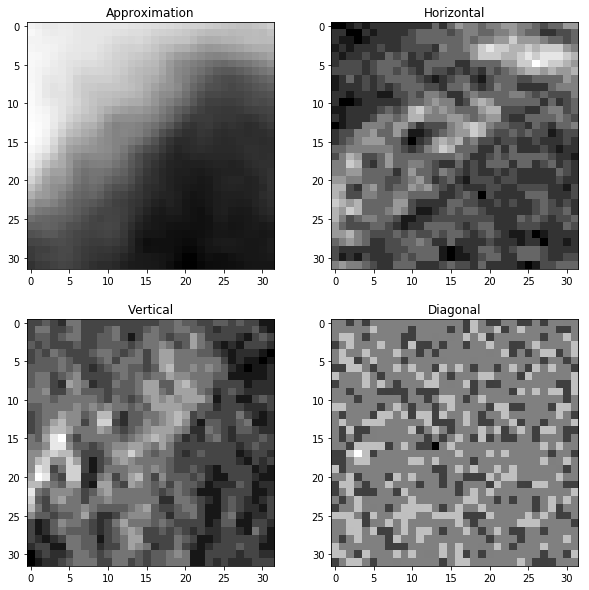

In [15]:
sample = train[20]
plot4subbands(sample[0], sample[1], sample[2], sample[3])

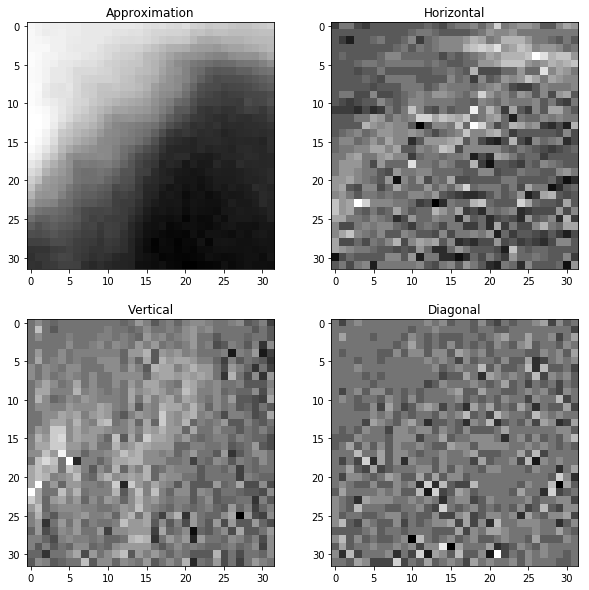

In [17]:
label = test[20]
plot4subbands(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [34]:
input_shape = train.shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])
shape_

(4, 32, 32)

In [137]:
test.shape

(263736, 4, 32, 32)

In [20]:
def fit_model(model, train, test) :
    filepath="weights.best" + "-{epoch:02d}-{val_loss:.2f}" + ".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=5)
    callbacks_list = [checkpoint]
    
    model.fit(train, test, validation_split=0.20, epochs=50, batch_size=64, verbose=1, callbacks = callbacks_list)

In [31]:
model = wavelet_mode()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 32, 32)   6464        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 64, 32, 32)   36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 64, 32, 32)   36928       conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_28 

In [141]:
fit_model(model, train, test)

Train on 210988 samples, validate on 52748 samples
Epoch 1/50
210988/210988 [==============================] - 295s 1ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 2/50
210988/210988 [==============================] - 284s 1ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/50
210988/210988 [==============================] - 287s 1ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/50
210988/210988 [==============================] - 292s 1ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/50
210988/210988 [==============================] - 292s 1ms/step - loss: 0.0032 - val_loss: 0.0032

Epoch 00005: val_loss improved from inf to 0.00322, saving model to weights.best-05-0.00.hdf5
Epoch 6/50
210988/210988 [==============================] - 292s 1ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/50
210988/210988 [==============================] - 288s 1ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/50
210988/210988 [==============================] - 283s 1ms/step - loss: 0.0032 - val_los

In [32]:
save_model(model, "delete")

In [33]:
ycbcr_model = load_model("SRCNN_ycbcr_50_residual", )

#### Original image and bicubic interpolated image

In [34]:
TEST_FILE5 = "datasets/SR_Test/Set5/"
def get_test_dataset(test_name = TEST_FILE5) :
    vald_pil = load_images(TEST_FILE5)
    return vald_pil

In [35]:
index=3
vald_pil = get_test_dataset()
val_img = vald_pil[index]

org, bic = get_input_images(val_img, 4.)
h, w = utility.getSize(org)

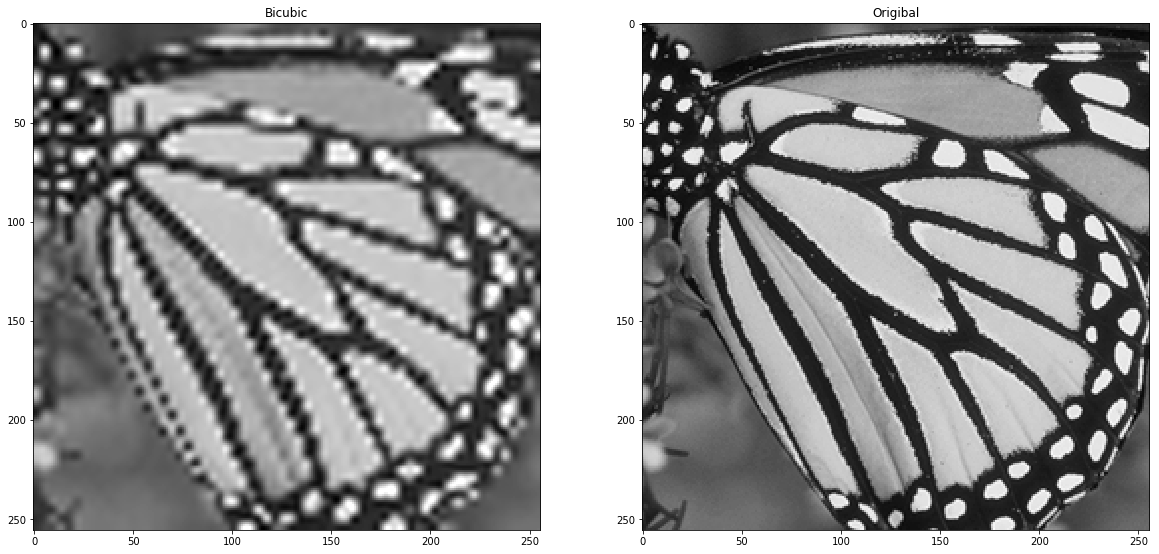

In [36]:
plot_images([org, bic], ["Origibal", "Bicubic"], size=(20, 10), ch=1)

In [37]:
stride = 30
sub_img, _ = generate_patches(bic, patch_size=64, stride = stride )

sub_img = [img.astype(float) / 255. for img in sub_img]
sub_img[0].shape

(64, 64)

In [38]:
wavelets = np.zeros((len(sub_img), 4, 32, 32))

for i in range(len(sub_img)) :
    wavelets[i] = get_wavelets(sub_img[i])

In [39]:
wavelets.shape

(49, 4, 32, 32)

In [40]:
pred_wave = ycbcr_model.predict(wavelets)

In [42]:
hd_wave = pred_wave

window_size = 64
sub_imgs = np.zeros((len(hd_wave), window_size, window_size))
for i in range(len(hd_wave)) :    
    sub_imgs[i] = iwavelet(hd_wave[i])*255.

sub_imgs = sub_imgs.astype('uint8')

In [43]:
sub_imgs.shape

(49, 64, 64)

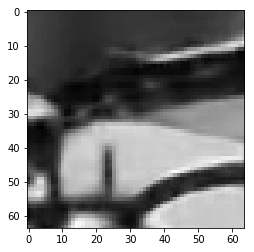

In [44]:
plt.imshow(sub_imgs[1], 'gray')

In [45]:
im = patch_to_image(sub_imgs, h, w, label_size=64,stride = stride)

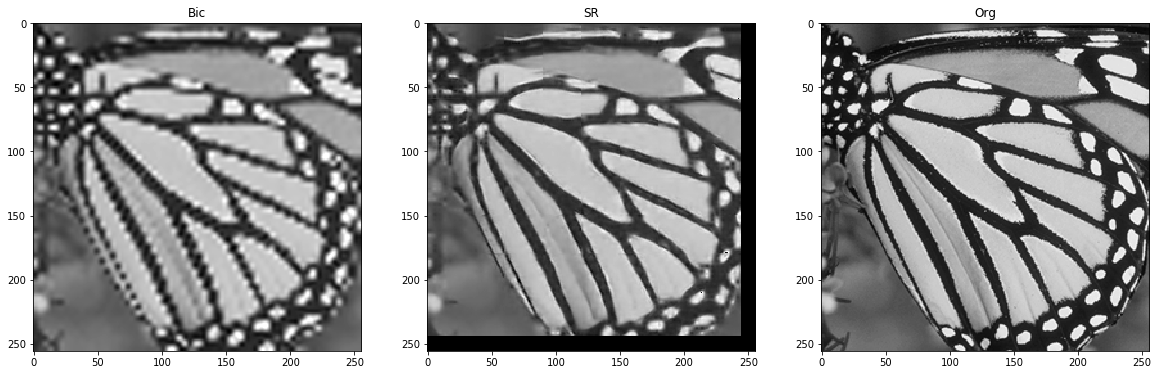

In [46]:
plot_images ([org, bic, im], ["Org", "Bic", "SR"], size= (20,20), ch=1) 

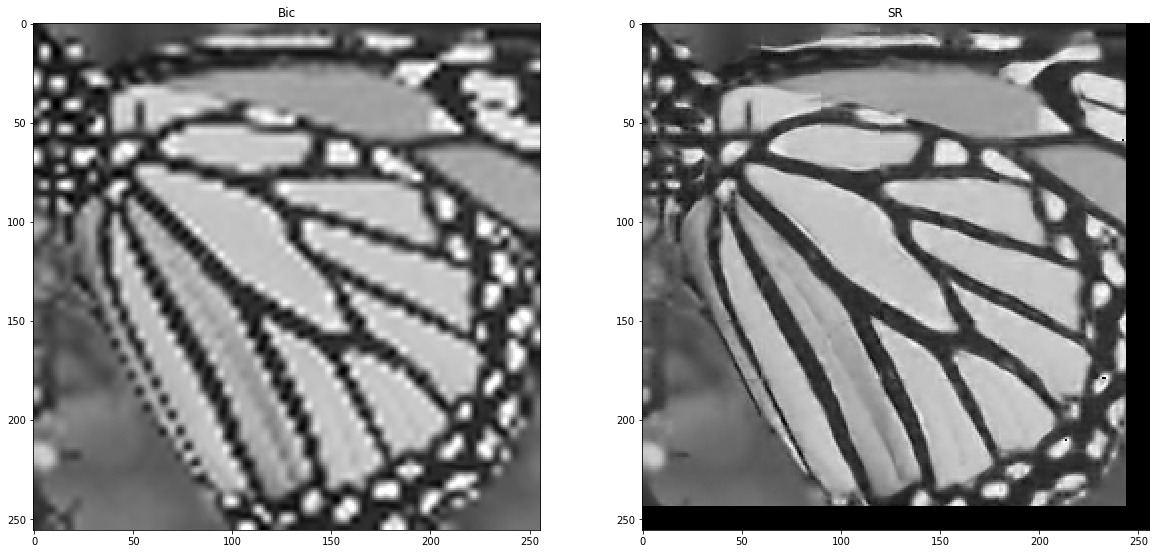

In [47]:
plot_images ([im, bic], ["SR", "Bic"], size= (20,20), ch=1) 